In [1]:
import pandas as pd

# Syn Flood Attack Analysis

In [2]:
connection_start = pd.read_csv("start-time-with-syn-flood.csv", delimiter='\t', names=['RT', 'SI', 'DI', 'SP', 'DP'])
connection_end = pd.read_csv("end-time-with-syn-flood.csv", delimiter='\t', names=['RT', 'SI', 'DI', 'SP', 'DP'])

In [3]:
connection_start.head(3)

,RT,SI,DI,SP,DP
0,0.000000,192.168.56.102,192.168.56.104,57102,80
1,5.627187,192.168.56.102,192.168.56.104,54980,80
2,20.041441,192.168.56.102,192.168.56.104,1494,80


In [4]:
connection_end.head(3)

,RT,SI,DI,SP,DP
0,20.042627,192.168.56.102,192.168.56.104,1494,80
1,20.045181,192.168.56.102,192.168.56.104,1495,80
2,20.049515,192.168.56.102,192.168.56.104,1496,80


In [5]:
connection_start['duration'] = 0

In [6]:
processed_rows = []


for row in range(len(connection_start)):

    if row in processed_rows:
        continue

    SI = connection_start['SI'][row]
    DI = connection_start['DI'][row]
    SP = connection_start['SP'][row]
    DP = connection_start['DP'][row]
    
    mask_end = ((connection_end['SI'] == SI) & 
            (connection_end['DI'] == DI) & 
            (connection_end['SP'] == SP) & 
            (connection_end['DP'] == DP))
    
    mask_start = ((connection_start['SI'] == SI) & 
            (connection_start['DI'] == DI) & 
            (connection_start['SP'] == SP) & 
            (connection_start['DP'] == DP))
    
    matching_rows_end = connection_end[mask_end]
    matching_rows_start = connection_start[mask_start]

    matching_indices = connection_start[mask_start].index.tolist()
    processed_rows.extend(matching_indices)

    start_rt_values = matching_rows_start['RT'].values if not matching_rows_start.empty else []
    end_rt_values = matching_rows_end['RT'].values if not matching_rows_end.empty else []
    
    if not matching_rows_end.empty:

        len_start = len(start_rt_values)
        len_end = len(end_rt_values)
        
        durations = []
        
        min_len = min(len_start, len_end)
        for i in range(min_len):
            if i < len_end:
                duration = end_rt_values[i] - start_rt_values[i]
                durations.append(duration)
        
        max_len = max(len_start, len_end)
        for i in range(min_len, max_len):
            durations.append(100)
        
        if durations:
            connection_start.loc[mask_start, 'duration'] = durations
        else:
            connection_start.loc[mask_start, 'duration'] = [100]
    else:
        connection_start.loc[mask_start, 'duration'] = 100.00

/tmp/ipykernel_18457/789274676.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[np.float64(51.482093613)]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  connection_start.loc[mask_start, 'duration'] = durations


In [7]:
connection_start.to_csv("duration-with-syn-flood.csv")

In [8]:
connection_start

,RT,SI,DI,SP,DP,duration
0,0.000000,192.168.56.102,192.168.56.104,57102,80,51.482094
1,5.627187,192.168.56.102,192.168.56.104,54980,80,51.456096
2,20.041441,192.168.56.102,192.168.56.104,1494,80,0.001186
3,20.044467,192.168.56.102,192.168.56.104,1495,80,0.000714
4,20.047838,192.168.56.102,192.168.56.104,1496,80,0.001677
...,...,...,...,...,...,...
10357,80.098205,192.168.56.102,192.168.56.104,11849,80,0.005978
10358,80.115955,192.168.56.102,192.168.56.104,11850,80,0.009222
10359,80.131477,192.168.56.102,192.168.56.104,11851,80,0.019498
10360,80.154904,192.168.56.102,192.168.56.104,11852,80,0.005175


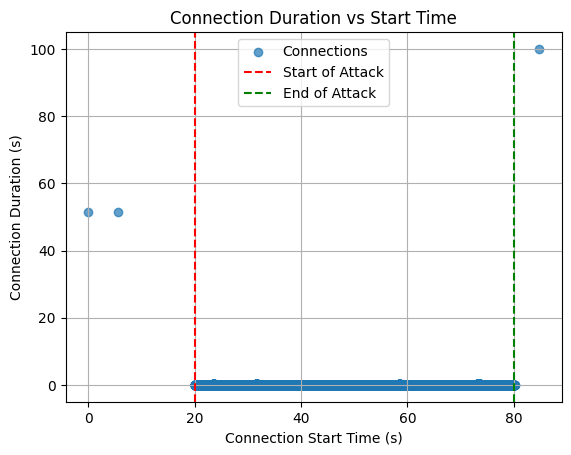

In [9]:
import matplotlib.pyplot as plt
df = pd.read_csv("duration-with-syn-flood.csv")  # Columns: start_time, duration
# plt.scatter(df["RT"], df["duration"])
# plt.xlabel("Connection Start Time (s)")
# plt.ylabel("Connection Duration (s)")
# plt.title("Connection Duration vs Start Time")
# plt.show()
# Ensure numeric values
df["RT"] = pd.to_numeric(df["RT"], errors="coerce")
df["duration"] = pd.to_numeric(df["duration"], errors="coerce")

# Drop NaN values
df = df.dropna(subset=["RT", "duration"])

# Plot scatter
plt.scatter(df["RT"], df["duration"], label="Connections", alpha=0.7)

# Add vertical lines at x = 20 and x = 80
plt.axvline(x=20, color='r', linestyle='--', label="Start of Attack")
plt.axvline(x=80, color='g', linestyle='--', label="End of Attack")

# Labels and title
plt.xlabel("Connection Start Time (s)")
plt.ylabel("Connection Duration (s)")
plt.title("Connection Duration vs Start Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Analysis After Mitigation of Syn Flood
#### To Mitigate Syn Flood to we Change the following linux kernel parameters value to default 
1. net.ipv4_max_syn_backlog = 128
2. net.ipv4.tcp_syncookies = 1
3. net.ipv4.tcp_synack_retries = 5